# Imports and Utility Functions

In [ ]:
!sudo apt update
!sudo apt install xvfb
!pip install gym
!pip install ma-gym
!pip3 install box2d-py
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/graphics-driver

In [ ]:
import os
from pyvirtualdisplay import Display
import gym
import ma_gym
from gym import spaces
from gym import logger as gymlogger
from ma_gym.wrappers import Monitor
gymlogger.set_level(40)
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import clear_output
from IPython import display as ipythondisplay
import PIL

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as T

from collections import namedtuple
from tqdm import tqdm
import time 
from google.colab import widgets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.pos  = 0
    
    def push(self, state, action, reward, next_state, done):

        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size):
        
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        samples = [self.buffer[idx] for idx in indices]
        
        batch = np.asarray(list(zip(*samples)))
        states = np.concatenate(batch[0])
        actions = batch[1]
        rewards = batch[2]
        next_states = np.concatenate(batch[3])
        dones = batch[4]
        
        return states, actions, rewards, next_states, dones, indices

    def __len__(self):
        return len(self.buffer)

In [ ]:
def get_target(model, next_state, reward, gamma, done):
  model.eval()
  with torch.no_grad():
      next_q_values = model(next_state)      # next_q_values has dimensions batch, num_actions
      next_q_value = next_q_values.max(1)[0]

  expected_q_value = reward+gamma*next_q_value*(1-done)  # If terminal state (1-done) will be 0.
  
  return expected_q_value

In [ ]:
def loss_and_back(replay_buffer, batch_size, device, dqn_model, target_model, gamma, optimizer):
    state, action, reward, next_state, done, indices = replay_buffer.sample(batch_size) 

    state = torch.tensor(state.astype('float') ).float().to(device) 
    next_state = torch.tensor(next_state.astype('float') ).float().to(device)
    action = torch.tensor(action.astype('float') ).long().to(device)
    reward = torch.tensor(reward.astype('float') ).float().to(device)
    done = torch.tensor(done.astype('float') ).float().to(device)
    
    dqn_model.train()

    q_values = dqn_model(state) #feedforward

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1) # Q values for actions sampled from the replay buffer

    expected_q_value = get_target(target_model, next_state, reward, gamma, done)

    loss = F.mse_loss(q_value,expected_q_value)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions, device):
        super().__init__()

        # sequential model
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 64),  # INPUT LAYER
            nn.ReLU(),
            nn.Linear(64, 128),  # HIDDEN LAYER 1
            nn.ReLU(),
            nn.Linear(128, 256),  # HIDDEN LAYER 2
            nn.ReLU(),
            nn.Linear(256, num_actions),  # OUTPUT LAYER
        )

        self.num_actions = num_actions
        self.device = device

    def forward(self, x):
        op = self.layers(x)
        return op

    def act(self, state, epsilon, env, i):
        state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        if random.random() > epsilon:
            q_value = self.forward(state)
            action = q_value.max(1)[1].data[0].item()
        else:
            action = np.random.choice(env.action_space[i].n)

        return action

In [ ]:
def update_target(dqn_model, target_model):
    target_model.load_state_dict(dqn_model.state_dict())


def basis_transform(state):
    return np.asarray(state)

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
# ---- Source : https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
def evalTrainedModel(env_name, model_1, model_2):
    env = gym.make(env_name)
    env = wrap_env(env)

    frame = env.reset()
    rewards_list_ag1 = []
    rewards_list_ag2 = []

    for episode in range(1, 11):
        done = False
        counter = 0
        tot_reward_1 = 0
        tot_reward_2 = 0

        while not done:
            with torch.no_grad():
                inpt_1 = torch.tensor(frame[0]).float().unsqueeze(0).to(device)
                inpt_2 = torch.tensor(frame[1]).float().unsqueeze(0).to(device)

                action_1 = model_1(inpt_1).squeeze().argmax().item()
                action_2 = model_2(inpt_2).squeeze().argmax().item()

                frame, reward, is_done, _ = env.step([action_1, action_2])

                counter += 1
                tot_reward_1 += reward[0]
                tot_reward_2 += reward[1]

                if is_done[0] and is_done[1]:
                    done = True

            if done:
                rewards_list_ag1.append(tot_reward_1)
                rewards_list_ag2.append(tot_reward_2)

                frame = env.reset()

    plt.figure(figsize=(16, 8))
    plt.plot(rewards_list_ag1, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Reward per Episode')
    plt.title('Agent 1')

    plt.figure(figsize=(16, 8))
    plt.plot(rewards_list_ag2, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Reward per Episode')
    plt.title('Agent 2')

    plt.figure(figsize=(16, 8))
    plt.plot([(x + y) / 2 for x, y in zip(rewards_list_ag1, rewards_list_ag2)], color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward per Episode')
    plt.title('For both Agents')

    env.close()
    show_video()

In [ ]:
def switch_main(env_name=None, num_episodes=None, batch_size=None, gamma=None, learningrate=None, epsilon_start=None,
                   epsilon_final=None, epsilon_decay=None):
    env = gym.make(env_name)
    env = wrap_env(env)

    epsilon_by_frame_CP = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(
        -1. * frame_idx / epsilon_decay)

    dqn_model_ag1 = DQN(env.observation_space[0].shape[0], env.action_space[0].n, device).to(device)
    target_model_ag1 = DQN(env.observation_space[0].shape[0], env.action_space[0].n, device).to(device)

    dqn_model_ag2 = DQN(env.observation_space[1].shape[0], env.action_space[1].n, device).to(device)
    target_model_ag2 = DQN(env.observation_space[1].shape[0], env.action_space[1].n, device).to(device)

    optimizer_1 = optim.Adam(dqn_model_ag1.parameters(), lr=learningrate)
    optimizer_2 = optim.Adam(dqn_model_ag2.parameters(), lr=learningrate)

    replay_buffer_1 = ReplayBuffer(100000)
    replay_buffer_2 = ReplayBuffer(100000)

    update_target(dqn_model_ag1, target_model_ag1)
    update_target(dqn_model_ag2, target_model_ag2)

    losses_1 = []
    losses_2 = []

    all_rewards_ag1 = []
    all_rewards_ag2 = []

    epsilons = []
    timesteps = []

    for ep_ in range(num_episodes):
        print('======== Episode : {} ========'.format(ep_))
        epsilon = epsilon_by_frame_CP(ep_)
        epsilons.append(epsilon)

        state = env.reset()
        state_1 = state[0]
        state_2 = state[1]

        is_done = False
        count = 0
        episode_reward_1 = 0
        episode_reward_2 = 0

        while not is_done:
            count += 1
            action_1 = dqn_model_ag1.act(state_1, epsilon, env, 0)
            action_2 = dqn_model_ag2.act(state_2, epsilon, env, 1)

            next_state, reward, done, info = env.step([action_1, action_2])
            print([action_1, action_2])
            print(next_state)
            print(reward)

            next_state_1 = basis_transform(next_state[0])
            next_state_2 = basis_transform(next_state[1])

            replay_buffer_1.push(state_1, action_1, reward[0], next_state_1, done[0])
            replay_buffer_2.push(state_2, action_2, reward[1], next_state_2, done[1])

            state_1 = next_state_1
            state_2 = next_state_2

            episode_reward_1 += reward[0]
            episode_reward_2 += reward[1]

            if done[0] and done[1]:
                is_done = True

        timesteps.append(count)
        all_rewards_ag1.append(episode_reward_1)
        all_rewards_ag2.append(episode_reward_2)

        if len(replay_buffer_1) > batch_size:
            loss = loss_and_back(replay_buffer_1, batch_size, device, dqn_model_ag1, target_model_ag1, gamma,
                                 optimizer_1)
            losses_1.append(loss.item())

        if len(replay_buffer_2) > batch_size:
            loss = loss_and_back(replay_buffer_2, batch_size, device, dqn_model_ag2, target_model_ag2, gamma,
                                 optimizer_2)
            losses_2.append(loss.item())
        if (ep_+1) % 50 == 0:
            update_target(dqn_model_ag1, target_model_ag1)
            update_target(dqn_model_ag2, target_model_ag2)

    plt.figure(figsize=(12, 8))
    plt.plot(all_rewards_ag1, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Reward per Episode')
    plt.title('Agent 1')

    plt.figure(figsize=(12, 8))
    plt.plot(all_rewards_ag2, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Reward per Episode')
    plt.title('Agent 2')

    plt.figure(figsize=(12, 8))
    plt.plot([(x + y) / 2 for x, y in zip(all_rewards_ag1, all_rewards_ag2)], color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward per Episode')

    plt.figure(figsize=(12, 8))
    plt.plot(np.cumsum([(x + y) / 2 for x, y in zip(all_rewards_ag1, all_rewards_ag2)]), color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Average Cumulative Reward per Episode')

    plt.figure(figsize=(12, 8))
    plt.plot(epsilons, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Epsilon')

    plt.figure(figsize=(12, 8))
    plt.plot(timesteps, color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Timesteps Taken')

    plt.figure(figsize=(12, 8))
    plt.plot([(x + y) / 2 for x, y in zip(losses_1, losses_2)], color='r')
    plt.xlabel('Episodes')
    plt.ylabel('Average Loss')

    return dqn_model_ag1, dqn_model_ag2

======== Episode : 0 ========
======== Episode : 1 ========
======== Episode : 2 ========
======== Episode : 3 ========
======== Episode : 4 ========
======== Episode : 5 ========
======== Episode : 6 ========
======== Episode : 7 ========
======== Episode : 8 ========


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 9 ========
======== Episode : 10 ========
======== Episode : 11 ========
======== Episode : 12 ========
======== Episode : 13 ========
======== Episode : 14 ========
======== Episode : 15 ========
======== Episode : 16 ========
======== Episode : 17 ========
======== Episode : 18 ========
======== Episode : 19 ========
======== Episode : 20 ========
======== Episode : 21 ========
======== Episode : 22 ========
======== Episode : 23 ========
======== Episode : 24 ========
======== Episode : 25 ========
======== Episode : 26 ========
======== Episode : 27 ========


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 28 ========
======== Episode : 29 ========
======== Episode : 30 ========
======== Episode : 31 ========
======== Episode : 32 ========
======== Episode : 33 ========
======== Episode : 34 ========
======== Episode : 35 ========
======== Episode : 36 ========
======== Episode : 37 ========
======== Episode : 38 ========
======== Episode : 39 ========
======== Episode : 40 ========
======== Episode : 41 ========
======== Episode : 42 ========
======== Episode : 43 ========
======== Episode : 44 ========
======== Episode : 45 ========
======== Episode : 46 ========
======== Episode : 47 ========
======== Episode : 48 ========
======== Episode : 49 ========
======== Episode : 50 ========
======== Episode : 51 ========
======== Episode : 52 ========
======== Episode : 53 ========
======== Episode : 54 ========
======== Episode : 55 ========
======== Episode : 56 ========
======== Episode : 57 ========
======== Episode : 58 ========
======== Episode : 59 ========
========

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 65 ========
======== Episode : 66 ========
======== Episode : 67 ========
======== Episode : 68 ========
======== Episode : 69 ========
======== Episode : 70 ========
======== Episode : 71 ========
======== Episode : 72 ========
======== Episode : 73 ========
======== Episode : 74 ========
======== Episode : 75 ========
======== Episode : 76 ========
======== Episode : 77 ========
======== Episode : 78 ========
======== Episode : 79 ========
======== Episode : 80 ========
======== Episode : 81 ========
======== Episode : 82 ========
======== Episode : 83 ========
======== Episode : 84 ========
======== Episode : 85 ========
======== Episode : 86 ========
======== Episode : 87 ========
======== Episode : 88 ========
======== Episode : 89 ========
======== Episode : 90 ========
======== Episode : 91 ========
======== Episode : 92 ========
======== Episode : 93 ========
======== Episode : 94 ========
======== Episode : 95 ========
======== Episode : 96 ========
========

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 126 ========
======== Episode : 127 ========
======== Episode : 128 ========
======== Episode : 129 ========
======== Episode : 130 ========
======== Episode : 131 ========
======== Episode : 132 ========
======== Episode : 133 ========
======== Episode : 134 ========
======== Episode : 135 ========
======== Episode : 136 ========
======== Episode : 137 ========
======== Episode : 138 ========
======== Episode : 139 ========
======== Episode : 140 ========
======== Episode : 141 ========
======== Episode : 142 ========
======== Episode : 143 ========
======== Episode : 144 ========
======== Episode : 145 ========
======== Episode : 146 ========
======== Episode : 147 ========
======== Episode : 148 ========
======== Episode : 149 ========
======== Episode : 150 ========
======== Episode : 151 ========
======== Episode : 152 ========
======== Episode : 153 ========
======== Episode : 154 ========
======== Episode : 155 ========
======== Episode : 156 ========
========

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 217 ========
======== Episode : 218 ========
======== Episode : 219 ========
======== Episode : 220 ========
======== Episode : 221 ========
======== Episode : 222 ========
======== Episode : 223 ========
======== Episode : 224 ========
======== Episode : 225 ========
======== Episode : 226 ========
======== Episode : 227 ========
======== Episode : 228 ========
======== Episode : 229 ========
======== Episode : 230 ========
======== Episode : 231 ========
======== Episode : 232 ========
======== Episode : 233 ========
======== Episode : 234 ========
======== Episode : 235 ========
======== Episode : 236 ========
======== Episode : 237 ========
======== Episode : 238 ========
======== Episode : 239 ========
======== Episode : 240 ========
======== Episode : 241 ========
======== Episode : 242 ========
======== Episode : 243 ========
======== Episode : 244 ========
======== Episode : 245 ========
======== Episode : 246 ========
======== Episode : 247 ========
========

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 344 ========
======== Episode : 345 ========
======== Episode : 346 ========
======== Episode : 347 ========
======== Episode : 348 ========
======== Episode : 349 ========
======== Episode : 350 ========
======== Episode : 351 ========
======== Episode : 352 ========
======== Episode : 353 ========
======== Episode : 354 ========
======== Episode : 355 ========
======== Episode : 356 ========
======== Episode : 357 ========
======== Episode : 358 ========
======== Episode : 359 ========
======== Episode : 360 ========
======== Episode : 361 ========
======== Episode : 362 ========
======== Episode : 363 ========
======== Episode : 364 ========
======== Episode : 365 ========
======== Episode : 366 ========
======== Episode : 367 ========
======== Episode : 368 ========
======== Episode : 369 ========
======== Episode : 370 ========
======== Episode : 371 ========
======== Episode : 372 ========
======== Episode : 373 ========
======== Episode : 374 ========
========

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 513 ========
======== Episode : 514 ========
======== Episode : 515 ========
======== Episode : 516 ========
======== Episode : 517 ========
======== Episode : 518 ========
======== Episode : 519 ========
======== Episode : 520 ========
======== Episode : 521 ========
======== Episode : 522 ========
======== Episode : 523 ========
======== Episode : 524 ========
======== Episode : 525 ========
======== Episode : 526 ========
======== Episode : 527 ========
======== Episode : 528 ========
======== Episode : 529 ========
======== Episode : 530 ========
======== Episode : 531 ========
======== Episode : 532 ========
======== Episode : 533 ========
======== Episode : 534 ========
======== Episode : 535 ========
======== Episode : 536 ========
======== Episode : 537 ========
======== Episode : 538 ========
======== Episode : 539 ========
======== Episode : 540 ========
======== Episode : 541 ========
======== Episode : 542 ========
======== Episode : 543 ========
========

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 730 ========
======== Episode : 731 ========
======== Episode : 732 ========
======== Episode : 733 ========
======== Episode : 734 ========
======== Episode : 735 ========
======== Episode : 736 ========
======== Episode : 737 ========
======== Episode : 738 ========
======== Episode : 739 ========
======== Episode : 740 ========
======== Episode : 741 ========
======== Episode : 742 ========
======== Episode : 743 ========
======== Episode : 744 ========
======== Episode : 745 ========
======== Episode : 746 ========
======== Episode : 747 ========
======== Episode : 748 ========
======== Episode : 749 ========
======== Episode : 750 ========
======== Episode : 751 ========
======== Episode : 752 ========
======== Episode : 753 ========
======== Episode : 754 ========
======== Episode : 755 ========
======== Episode : 756 ========
======== Episode : 757 ========
======== Episode : 758 ========
======== Episode : 759 ========
======== Episode : 760 ========
========

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 1001 ========
======== Episode : 1002 ========
======== Episode : 1003 ========
======== Episode : 1004 ========
======== Episode : 1005 ========
======== Episode : 1006 ========
======== Episode : 1007 ========
======== Episode : 1008 ========
======== Episode : 1009 ========
======== Episode : 1010 ========
======== Episode : 1011 ========
======== Episode : 1012 ========
======== Episode : 1013 ========
======== Episode : 1014 ========
======== Episode : 1015 ========
======== Episode : 1016 ========
======== Episode : 1017 ========
======== Episode : 1018 ========
======== Episode : 1019 ========
======== Episode : 1020 ========
======== Episode : 1021 ========
======== Episode : 1022 ========
======== Episode : 1023 ========
======== Episode : 1024 ========
======== Episode : 1025 ========
======== Episode : 1026 ========
======== Episode : 1027 ========
======== Episode : 1028 ========
======== Episode : 1029 ========
======== Episode : 1030 ========
======== E

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 2001 ========
======== Episode : 2002 ========
======== Episode : 2003 ========
======== Episode : 2004 ========
======== Episode : 2005 ========
======== Episode : 2006 ========
======== Episode : 2007 ========
======== Episode : 2008 ========
======== Episode : 2009 ========
======== Episode : 2010 ========
======== Episode : 2011 ========
======== Episode : 2012 ========
======== Episode : 2013 ========
======== Episode : 2014 ========
======== Episode : 2015 ========
======== Episode : 2016 ========
======== Episode : 2017 ========
======== Episode : 2018 ========
======== Episode : 2019 ========
======== Episode : 2020 ========
======== Episode : 2021 ========
======== Episode : 2022 ========
======== Episode : 2023 ========
======== Episode : 2024 ========
======== Episode : 2025 ========
======== Episode : 2026 ========
======== Episode : 2027 ========
======== Episode : 2028 ========
======== Episode : 2029 ========
======== Episode : 2030 ========
======== E

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 3001 ========
======== Episode : 3002 ========
======== Episode : 3003 ========
======== Episode : 3004 ========
======== Episode : 3005 ========
======== Episode : 3006 ========
======== Episode : 3007 ========
======== Episode : 3008 ========
======== Episode : 3009 ========
======== Episode : 3010 ========
======== Episode : 3011 ========
======== Episode : 3012 ========
======== Episode : 3013 ========
======== Episode : 3014 ========
======== Episode : 3015 ========
======== Episode : 3016 ========
======== Episode : 3017 ========
======== Episode : 3018 ========
======== Episode : 3019 ========
======== Episode : 3020 ========
======== Episode : 3021 ========
======== Episode : 3022 ========
======== Episode : 3023 ========
======== Episode : 3024 ========
======== Episode : 3025 ========
======== Episode : 3026 ========
======== Episode : 3027 ========
======== Episode : 3028 ========
======== Episode : 3029 ========
======== Episode : 3030 ========
======== E

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 4001 ========
======== Episode : 4002 ========
======== Episode : 4003 ========
======== Episode : 4004 ========
======== Episode : 4005 ========
======== Episode : 4006 ========
======== Episode : 4007 ========
======== Episode : 4008 ========
======== Episode : 4009 ========
======== Episode : 4010 ========
======== Episode : 4011 ========
======== Episode : 4012 ========
======== Episode : 4013 ========
======== Episode : 4014 ========
======== Episode : 4015 ========
======== Episode : 4016 ========
======== Episode : 4017 ========
======== Episode : 4018 ========
======== Episode : 4019 ========
======== Episode : 4020 ========
======== Episode : 4021 ========
======== Episode : 4022 ========
======== Episode : 4023 ========
======== Episode : 4024 ========
======== Episode : 4025 ========
======== Episode : 4026 ========
======== Episode : 4027 ========
======== Episode : 4028 ========
======== Episode : 4029 ========
======== Episode : 4030 ========
======== E

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 5001 ========
======== Episode : 5002 ========
======== Episode : 5003 ========
======== Episode : 5004 ========
======== Episode : 5005 ========
======== Episode : 5006 ========
======== Episode : 5007 ========
======== Episode : 5008 ========
======== Episode : 5009 ========
======== Episode : 5010 ========
======== Episode : 5011 ========
======== Episode : 5012 ========
======== Episode : 5013 ========
======== Episode : 5014 ========
======== Episode : 5015 ========
======== Episode : 5016 ========
======== Episode : 5017 ========
======== Episode : 5018 ========
======== Episode : 5019 ========
======== Episode : 5020 ========
======== Episode : 5021 ========
======== Episode : 5022 ========
======== Episode : 5023 ========
======== Episode : 5024 ========
======== Episode : 5025 ========
======== Episode : 5026 ========
======== Episode : 5027 ========
======== Episode : 5028 ========
======== Episode : 5029 ========
======== Episode : 5030 ========
======== E

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 6001 ========
======== Episode : 6002 ========
======== Episode : 6003 ========
======== Episode : 6004 ========
======== Episode : 6005 ========
======== Episode : 6006 ========
======== Episode : 6007 ========
======== Episode : 6008 ========
======== Episode : 6009 ========
======== Episode : 6010 ========
======== Episode : 6011 ========
======== Episode : 6012 ========
======== Episode : 6013 ========
======== Episode : 6014 ========
======== Episode : 6015 ========
======== Episode : 6016 ========
======== Episode : 6017 ========
======== Episode : 6018 ========
======== Episode : 6019 ========
======== Episode : 6020 ========
======== Episode : 6021 ========
======== Episode : 6022 ========
======== Episode : 6023 ========
======== Episode : 6024 ========
======== Episode : 6025 ========
======== Episode : 6026 ========
======== Episode : 6027 ========
======== Episode : 6028 ========
======== Episode : 6029 ========
======== Episode : 6030 ========
======== E

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 7001 ========
======== Episode : 7002 ========
======== Episode : 7003 ========
======== Episode : 7004 ========
======== Episode : 7005 ========
======== Episode : 7006 ========
======== Episode : 7007 ========
======== Episode : 7008 ========
======== Episode : 7009 ========
======== Episode : 7010 ========
======== Episode : 7011 ========
======== Episode : 7012 ========
======== Episode : 7013 ========
======== Episode : 7014 ========
======== Episode : 7015 ========
======== Episode : 7016 ========
======== Episode : 7017 ========
======== Episode : 7018 ========
======== Episode : 7019 ========
======== Episode : 7020 ========
======== Episode : 7021 ========
======== Episode : 7022 ========
======== Episode : 7023 ========
======== Episode : 7024 ========
======== Episode : 7025 ========
======== Episode : 7026 ========
======== Episode : 7027 ========
======== Episode : 7028 ========
======== Episode : 7029 ========
======== Episode : 7030 ========
======== E

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 8001 ========
======== Episode : 8002 ========
======== Episode : 8003 ========
======== Episode : 8004 ========
======== Episode : 8005 ========
======== Episode : 8006 ========
======== Episode : 8007 ========
======== Episode : 8008 ========
======== Episode : 8009 ========
======== Episode : 8010 ========
======== Episode : 8011 ========
======== Episode : 8012 ========
======== Episode : 8013 ========
======== Episode : 8014 ========
======== Episode : 8015 ========
======== Episode : 8016 ========
======== Episode : 8017 ========
======== Episode : 8018 ========
======== Episode : 8019 ========
======== Episode : 8020 ========
======== Episode : 8021 ========
======== Episode : 8022 ========
======== Episode : 8023 ========
======== Episode : 8024 ========
======== Episode : 8025 ========
======== Episode : 8026 ========
======== Episode : 8027 ========
======== Episode : 8028 ========
======== Episode : 8029 ========
======== Episode : 8030 ========
======== E

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 9001 ========
======== Episode : 9002 ========
======== Episode : 9003 ========
======== Episode : 9004 ========
======== Episode : 9005 ========
======== Episode : 9006 ========
======== Episode : 9007 ========
======== Episode : 9008 ========
======== Episode : 9009 ========
======== Episode : 9010 ========
======== Episode : 9011 ========
======== Episode : 9012 ========
======== Episode : 9013 ========
======== Episode : 9014 ========
======== Episode : 9015 ========
======== Episode : 9016 ========
======== Episode : 9017 ========
======== Episode : 9018 ========
======== Episode : 9019 ========
======== Episode : 9020 ========
======== Episode : 9021 ========
======== Episode : 9022 ========
======== Episode : 9023 ========
======== Episode : 9024 ========
======== Episode : 9025 ========
======== Episode : 9026 ========
======== Episode : 9027 ========
======== Episode : 9028 ========
======== Episode : 9029 ========
======== Episode : 9030 ========
======== E

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 10001 ========
======== Episode : 10002 ========
======== Episode : 10003 ========
======== Episode : 10004 ========
======== Episode : 10005 ========
======== Episode : 10006 ========
======== Episode : 10007 ========
======== Episode : 10008 ========
======== Episode : 10009 ========
======== Episode : 10010 ========
======== Episode : 10011 ========
======== Episode : 10012 ========
======== Episode : 10013 ========
======== Episode : 10014 ========
======== Episode : 10015 ========
======== Episode : 10016 ========
======== Episode : 10017 ========
======== Episode : 10018 ========
======== Episode : 10019 ========
======== Episode : 10020 ========
======== Episode : 10021 ========
======== Episode : 10022 ========
======== Episode : 10023 ========
======== Episode : 10024 ========
======== Episode : 10025 ========
======== Episode : 10026 ========
======== Episode : 10027 ========
======== Episode : 10028 ========
======== Episode : 10029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 11001 ========
======== Episode : 11002 ========
======== Episode : 11003 ========
======== Episode : 11004 ========
======== Episode : 11005 ========
======== Episode : 11006 ========
======== Episode : 11007 ========
======== Episode : 11008 ========
======== Episode : 11009 ========
======== Episode : 11010 ========
======== Episode : 11011 ========
======== Episode : 11012 ========
======== Episode : 11013 ========
======== Episode : 11014 ========
======== Episode : 11015 ========
======== Episode : 11016 ========
======== Episode : 11017 ========
======== Episode : 11018 ========
======== Episode : 11019 ========
======== Episode : 11020 ========
======== Episode : 11021 ========
======== Episode : 11022 ========
======== Episode : 11023 ========
======== Episode : 11024 ========
======== Episode : 11025 ========
======== Episode : 11026 ========
======== Episode : 11027 ========
======== Episode : 11028 ========
======== Episode : 11029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 12001 ========
======== Episode : 12002 ========
======== Episode : 12003 ========
======== Episode : 12004 ========
======== Episode : 12005 ========
======== Episode : 12006 ========
======== Episode : 12007 ========
======== Episode : 12008 ========
======== Episode : 12009 ========
======== Episode : 12010 ========
======== Episode : 12011 ========
======== Episode : 12012 ========
======== Episode : 12013 ========
======== Episode : 12014 ========
======== Episode : 12015 ========
======== Episode : 12016 ========
======== Episode : 12017 ========
======== Episode : 12018 ========
======== Episode : 12019 ========
======== Episode : 12020 ========
======== Episode : 12021 ========
======== Episode : 12022 ========
======== Episode : 12023 ========
======== Episode : 12024 ========
======== Episode : 12025 ========
======== Episode : 12026 ========
======== Episode : 12027 ========
======== Episode : 12028 ========
======== Episode : 12029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 13001 ========
======== Episode : 13002 ========
======== Episode : 13003 ========
======== Episode : 13004 ========
======== Episode : 13005 ========
======== Episode : 13006 ========
======== Episode : 13007 ========
======== Episode : 13008 ========
======== Episode : 13009 ========
======== Episode : 13010 ========
======== Episode : 13011 ========
======== Episode : 13012 ========
======== Episode : 13013 ========
======== Episode : 13014 ========
======== Episode : 13015 ========
======== Episode : 13016 ========
======== Episode : 13017 ========
======== Episode : 13018 ========
======== Episode : 13019 ========
======== Episode : 13020 ========
======== Episode : 13021 ========
======== Episode : 13022 ========
======== Episode : 13023 ========
======== Episode : 13024 ========
======== Episode : 13025 ========
======== Episode : 13026 ========
======== Episode : 13027 ========
======== Episode : 13028 ========
======== Episode : 13029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 14001 ========
======== Episode : 14002 ========
======== Episode : 14003 ========
======== Episode : 14004 ========
======== Episode : 14005 ========
======== Episode : 14006 ========
======== Episode : 14007 ========
======== Episode : 14008 ========
======== Episode : 14009 ========
======== Episode : 14010 ========
======== Episode : 14011 ========
======== Episode : 14012 ========
======== Episode : 14013 ========
======== Episode : 14014 ========
======== Episode : 14015 ========
======== Episode : 14016 ========
======== Episode : 14017 ========
======== Episode : 14018 ========
======== Episode : 14019 ========
======== Episode : 14020 ========
======== Episode : 14021 ========
======== Episode : 14022 ========
======== Episode : 14023 ========
======== Episode : 14024 ========
======== Episode : 14025 ========
======== Episode : 14026 ========
======== Episode : 14027 ========
======== Episode : 14028 ========
======== Episode : 14029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 15001 ========
======== Episode : 15002 ========
======== Episode : 15003 ========
======== Episode : 15004 ========
======== Episode : 15005 ========
======== Episode : 15006 ========
======== Episode : 15007 ========
======== Episode : 15008 ========
======== Episode : 15009 ========
======== Episode : 15010 ========
======== Episode : 15011 ========
======== Episode : 15012 ========
======== Episode : 15013 ========
======== Episode : 15014 ========
======== Episode : 15015 ========
======== Episode : 15016 ========
======== Episode : 15017 ========
======== Episode : 15018 ========
======== Episode : 15019 ========
======== Episode : 15020 ========
======== Episode : 15021 ========
======== Episode : 15022 ========
======== Episode : 15023 ========
======== Episode : 15024 ========
======== Episode : 15025 ========
======== Episode : 15026 ========
======== Episode : 15027 ========
======== Episode : 15028 ========
======== Episode : 15029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 16001 ========
======== Episode : 16002 ========
======== Episode : 16003 ========
======== Episode : 16004 ========
======== Episode : 16005 ========
======== Episode : 16006 ========
======== Episode : 16007 ========
======== Episode : 16008 ========
======== Episode : 16009 ========
======== Episode : 16010 ========
======== Episode : 16011 ========
======== Episode : 16012 ========
======== Episode : 16013 ========
======== Episode : 16014 ========
======== Episode : 16015 ========
======== Episode : 16016 ========
======== Episode : 16017 ========
======== Episode : 16018 ========
======== Episode : 16019 ========
======== Episode : 16020 ========
======== Episode : 16021 ========
======== Episode : 16022 ========
======== Episode : 16023 ========
======== Episode : 16024 ========
======== Episode : 16025 ========
======== Episode : 16026 ========
======== Episode : 16027 ========
======== Episode : 16028 ========
======== Episode : 16029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 17001 ========
======== Episode : 17002 ========
======== Episode : 17003 ========
======== Episode : 17004 ========
======== Episode : 17005 ========
======== Episode : 17006 ========
======== Episode : 17007 ========
======== Episode : 17008 ========
======== Episode : 17009 ========
======== Episode : 17010 ========
======== Episode : 17011 ========
======== Episode : 17012 ========
======== Episode : 17013 ========
======== Episode : 17014 ========
======== Episode : 17015 ========
======== Episode : 17016 ========
======== Episode : 17017 ========
======== Episode : 17018 ========
======== Episode : 17019 ========
======== Episode : 17020 ========
======== Episode : 17021 ========
======== Episode : 17022 ========
======== Episode : 17023 ========
======== Episode : 17024 ========
======== Episode : 17025 ========
======== Episode : 17026 ========
======== Episode : 17027 ========
======== Episode : 17028 ========
======== Episode : 17029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 18001 ========
======== Episode : 18002 ========
======== Episode : 18003 ========
======== Episode : 18004 ========
======== Episode : 18005 ========
======== Episode : 18006 ========
======== Episode : 18007 ========
======== Episode : 18008 ========
======== Episode : 18009 ========
======== Episode : 18010 ========
======== Episode : 18011 ========
======== Episode : 18012 ========
======== Episode : 18013 ========
======== Episode : 18014 ========
======== Episode : 18015 ========
======== Episode : 18016 ========
======== Episode : 18017 ========
======== Episode : 18018 ========
======== Episode : 18019 ========
======== Episode : 18020 ========
======== Episode : 18021 ========
======== Episode : 18022 ========
======== Episode : 18023 ========
======== Episode : 18024 ========
======== Episode : 18025 ========
======== Episode : 18026 ========
======== Episode : 18027 ========
======== Episode : 18028 ========
======== Episode : 18029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 19002 ========
======== Episode : 19003 ========
======== Episode : 19004 ========
======== Episode : 19005 ========
======== Episode : 19006 ========
======== Episode : 19007 ========
======== Episode : 19008 ========
======== Episode : 19009 ========
======== Episode : 19010 ========
======== Episode : 19011 ========
======== Episode : 19012 ========
======== Episode : 19013 ========
======== Episode : 19014 ========
======== Episode : 19015 ========
======== Episode : 19016 ========
======== Episode : 19017 ========
======== Episode : 19018 ========
======== Episode : 19019 ========
======== Episode : 19020 ========
======== Episode : 19021 ========
======== Episode : 19022 ========
======== Episode : 19023 ========
======== Episode : 19024 ========
======== Episode : 19025 ========
======== Episode : 19026 ========
======== Episode : 19027 ========
======== Episode : 19028 ========
======== Episode : 19029 ========
======== Episode : 19030 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 20002 ========
======== Episode : 20003 ========
======== Episode : 20004 ========
======== Episode : 20005 ========
======== Episode : 20006 ========
======== Episode : 20007 ========
======== Episode : 20008 ========
======== Episode : 20009 ========
======== Episode : 20010 ========
======== Episode : 20011 ========
======== Episode : 20012 ========
======== Episode : 20013 ========
======== Episode : 20014 ========
======== Episode : 20015 ========
======== Episode : 20016 ========
======== Episode : 20017 ========
======== Episode : 20018 ========
======== Episode : 20019 ========
======== Episode : 20020 ========
======== Episode : 20021 ========
======== Episode : 20022 ========
======== Episode : 20023 ========
======== Episode : 20024 ========
======== Episode : 20025 ========
======== Episode : 20026 ========
======== Episode : 20027 ========
======== Episode : 20028 ========
======== Episode : 20029 ========
======== Episode : 20030 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 21002 ========
======== Episode : 21003 ========
======== Episode : 21004 ========
======== Episode : 21005 ========
======== Episode : 21006 ========
======== Episode : 21007 ========
======== Episode : 21008 ========
======== Episode : 21009 ========
======== Episode : 21010 ========
======== Episode : 21011 ========
======== Episode : 21012 ========
======== Episode : 21013 ========
======== Episode : 21014 ========
======== Episode : 21015 ========
======== Episode : 21016 ========
======== Episode : 21017 ========
======== Episode : 21018 ========
======== Episode : 21019 ========
======== Episode : 21020 ========
======== Episode : 21021 ========
======== Episode : 21022 ========
======== Episode : 21023 ========
======== Episode : 21024 ========
======== Episode : 21025 ========
======== Episode : 21026 ========
======== Episode : 21027 ========
======== Episode : 21028 ========
======== Episode : 21029 ========
======== Episode : 21030 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 22001 ========
======== Episode : 22002 ========
======== Episode : 22003 ========
======== Episode : 22004 ========
======== Episode : 22005 ========
======== Episode : 22006 ========
======== Episode : 22007 ========
======== Episode : 22008 ========
======== Episode : 22009 ========
======== Episode : 22010 ========
======== Episode : 22011 ========
======== Episode : 22012 ========
======== Episode : 22013 ========
======== Episode : 22014 ========
======== Episode : 22015 ========
======== Episode : 22016 ========
======== Episode : 22017 ========
======== Episode : 22018 ========
======== Episode : 22019 ========
======== Episode : 22020 ========
======== Episode : 22021 ========
======== Episode : 22022 ========
======== Episode : 22023 ========
======== Episode : 22024 ========
======== Episode : 22025 ========
======== Episode : 22026 ========
======== Episode : 22027 ========
======== Episode : 22028 ========
======== Episode : 22029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 23001 ========
======== Episode : 23002 ========
======== Episode : 23003 ========
======== Episode : 23004 ========
======== Episode : 23005 ========
======== Episode : 23006 ========
======== Episode : 23007 ========
======== Episode : 23008 ========
======== Episode : 23009 ========
======== Episode : 23010 ========
======== Episode : 23011 ========
======== Episode : 23012 ========
======== Episode : 23013 ========
======== Episode : 23014 ========
======== Episode : 23015 ========
======== Episode : 23016 ========
======== Episode : 23017 ========
======== Episode : 23018 ========
======== Episode : 23019 ========
======== Episode : 23020 ========
======== Episode : 23021 ========
======== Episode : 23022 ========
======== Episode : 23023 ========
======== Episode : 23024 ========
======== Episode : 23025 ========
======== Episode : 23026 ========
======== Episode : 23027 ========
======== Episode : 23028 ========
======== Episode : 23029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 24001 ========
======== Episode : 24002 ========
======== Episode : 24003 ========
======== Episode : 24004 ========
======== Episode : 24005 ========
======== Episode : 24006 ========
======== Episode : 24007 ========
======== Episode : 24008 ========
======== Episode : 24009 ========
======== Episode : 24010 ========
======== Episode : 24011 ========
======== Episode : 24012 ========
======== Episode : 24013 ========
======== Episode : 24014 ========
======== Episode : 24015 ========
======== Episode : 24016 ========
======== Episode : 24017 ========
======== Episode : 24018 ========
======== Episode : 24019 ========
======== Episode : 24020 ========
======== Episode : 24021 ========
======== Episode : 24022 ========
======== Episode : 24023 ========
======== Episode : 24024 ========
======== Episode : 24025 ========
======== Episode : 24026 ========
======== Episode : 24027 ========
======== Episode : 24028 ========
======== Episode : 24029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 25002 ========
======== Episode : 25003 ========
======== Episode : 25004 ========
======== Episode : 25005 ========
======== Episode : 25006 ========
======== Episode : 25007 ========
======== Episode : 25008 ========
======== Episode : 25009 ========
======== Episode : 25010 ========
======== Episode : 25011 ========
======== Episode : 25012 ========
======== Episode : 25013 ========
======== Episode : 25014 ========
======== Episode : 25015 ========
======== Episode : 25016 ========
======== Episode : 25017 ========
======== Episode : 25018 ========
======== Episode : 25019 ========
======== Episode : 25020 ========
======== Episode : 25021 ========
======== Episode : 25022 ========
======== Episode : 25023 ========
======== Episode : 25024 ========
======== Episode : 25025 ========
======== Episode : 25026 ========
======== Episode : 25027 ========
======== Episode : 25028 ========
======== Episode : 25029 ========
======== Episode : 25030 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 26001 ========
======== Episode : 26002 ========
======== Episode : 26003 ========
======== Episode : 26004 ========
======== Episode : 26005 ========
======== Episode : 26006 ========
======== Episode : 26007 ========
======== Episode : 26008 ========
======== Episode : 26009 ========
======== Episode : 26010 ========
======== Episode : 26011 ========
======== Episode : 26012 ========
======== Episode : 26013 ========
======== Episode : 26014 ========
======== Episode : 26015 ========
======== Episode : 26016 ========
======== Episode : 26017 ========
======== Episode : 26018 ========
======== Episode : 26019 ========
======== Episode : 26020 ========
======== Episode : 26021 ========
======== Episode : 26022 ========
======== Episode : 26023 ========
======== Episode : 26024 ========
======== Episode : 26025 ========
======== Episode : 26026 ========
======== Episode : 26027 ========
======== Episode : 26028 ========
======== Episode : 26029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 27002 ========
======== Episode : 27003 ========
======== Episode : 27004 ========
======== Episode : 27005 ========
======== Episode : 27006 ========
======== Episode : 27007 ========
======== Episode : 27008 ========
======== Episode : 27009 ========
======== Episode : 27010 ========
======== Episode : 27011 ========
======== Episode : 27012 ========
======== Episode : 27013 ========
======== Episode : 27014 ========
======== Episode : 27015 ========
======== Episode : 27016 ========
======== Episode : 27017 ========
======== Episode : 27018 ========
======== Episode : 27019 ========
======== Episode : 27020 ========
======== Episode : 27021 ========
======== Episode : 27022 ========
======== Episode : 27023 ========
======== Episode : 27024 ========
======== Episode : 27025 ========
======== Episode : 27026 ========
======== Episode : 27027 ========
======== Episode : 27028 ========
======== Episode : 27029 ========
======== Episode : 27030 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 28001 ========
======== Episode : 28002 ========
======== Episode : 28003 ========
======== Episode : 28004 ========
======== Episode : 28005 ========
======== Episode : 28006 ========
======== Episode : 28007 ========
======== Episode : 28008 ========
======== Episode : 28009 ========
======== Episode : 28010 ========
======== Episode : 28011 ========
======== Episode : 28012 ========
======== Episode : 28013 ========
======== Episode : 28014 ========
======== Episode : 28015 ========
======== Episode : 28016 ========
======== Episode : 28017 ========
======== Episode : 28018 ========
======== Episode : 28019 ========
======== Episode : 28020 ========
======== Episode : 28021 ========
======== Episode : 28022 ========
======== Episode : 28023 ========
======== Episode : 28024 ========
======== Episode : 28025 ========
======== Episode : 28026 ========
======== Episode : 28027 ========
======== Episode : 28028 ========
======== Episode : 28029 ========
======== Episo

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


======== Episode : 29001 ========
======== Episode : 29002 ========
======== Episode : 29003 ========
======== Episode : 29004 ========
======== Episode : 29005 ========
======== Episode : 29006 ========
======== Episode : 29007 ========
======== Episode : 29008 ========
======== Episode : 29009 ========
======== Episode : 29010 ========
======== Episode : 29011 ========
======== Episode : 29012 ========
======== Episode : 29013 ========
======== Episode : 29014 ========
======== Episode : 29015 ========
======== Episode : 29016 ========
======== Episode : 29017 ========
======== Episode : 29018 ========
======== Episode : 29019 ========
======== Episode : 29020 ========
======== Episode : 29021 ========
======== Episode : 29022 ========
======== Episode : 29023 ========
======== Episode : 29024 ========
======== Episode : 29025 ========
======== Episode : 29026 ========
======== Episode : 29027 ========
======== Episode : 29028 ========
======== Episode : 29029 ========
======== Episo

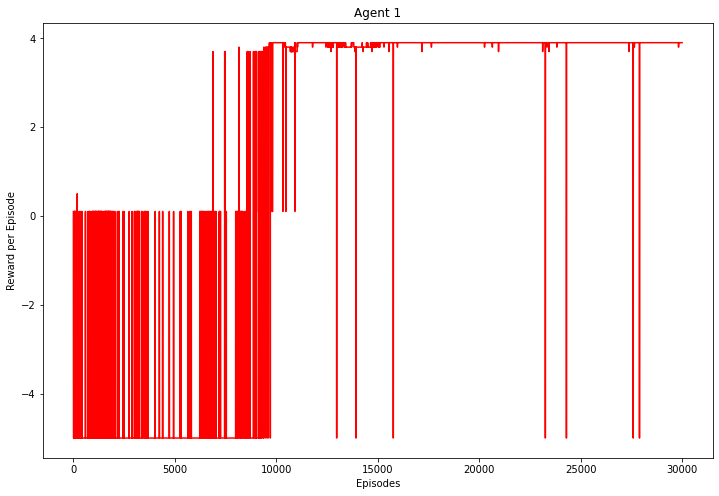

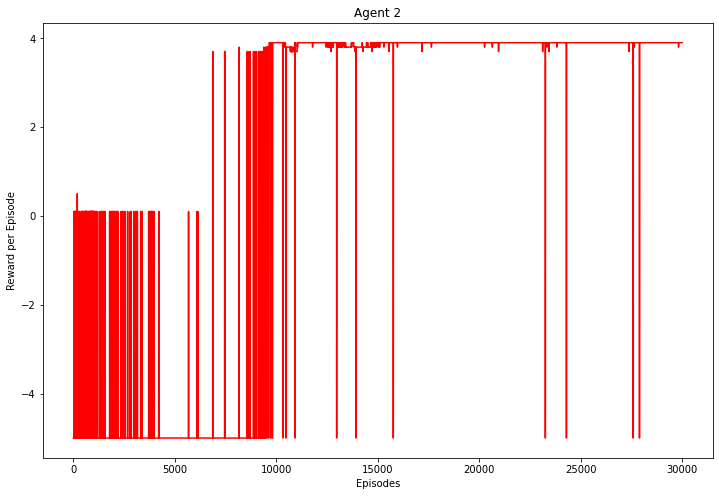

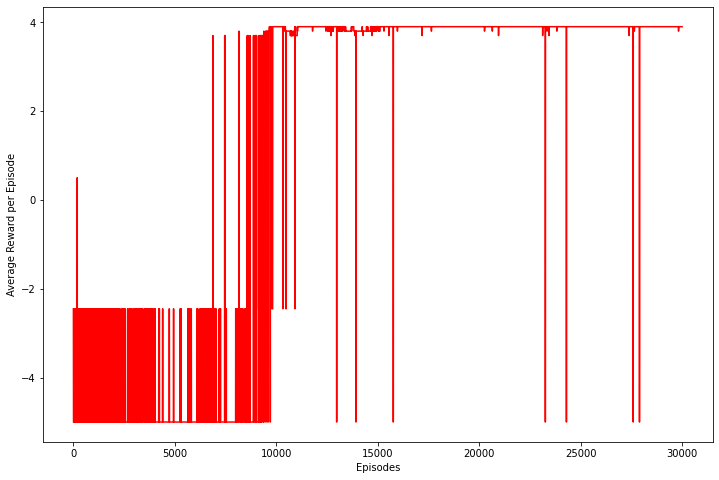

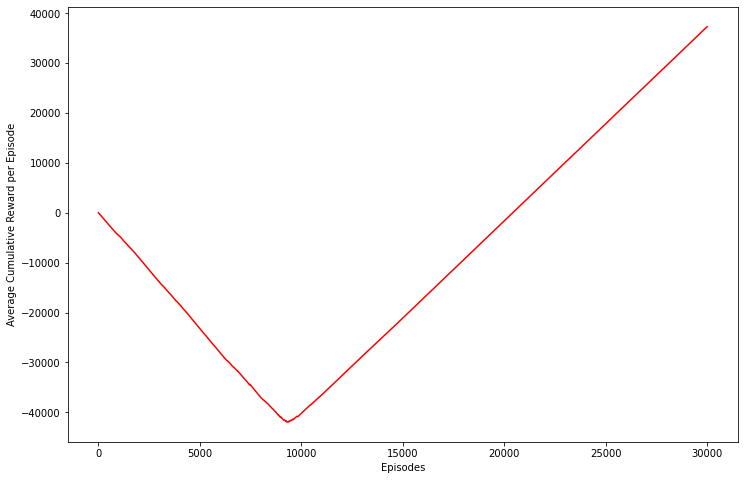

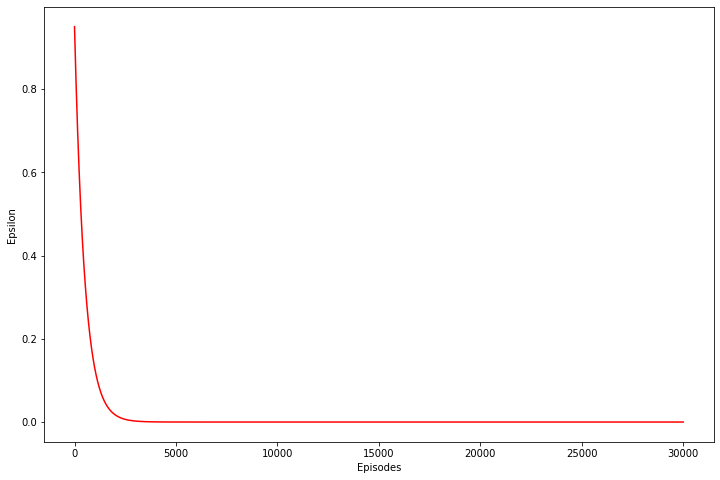

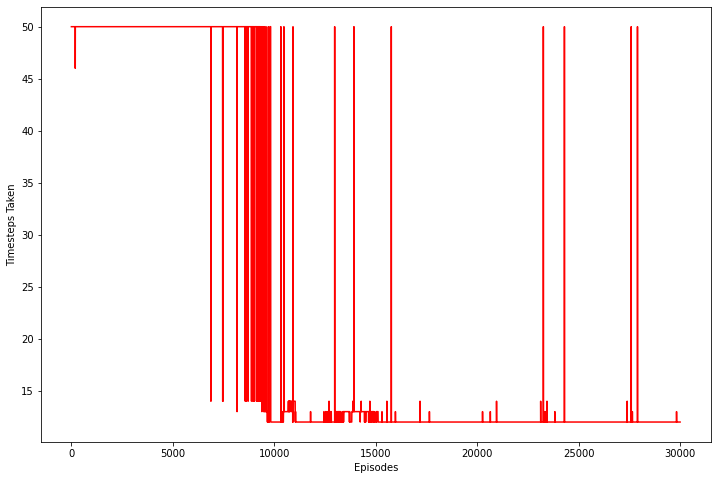

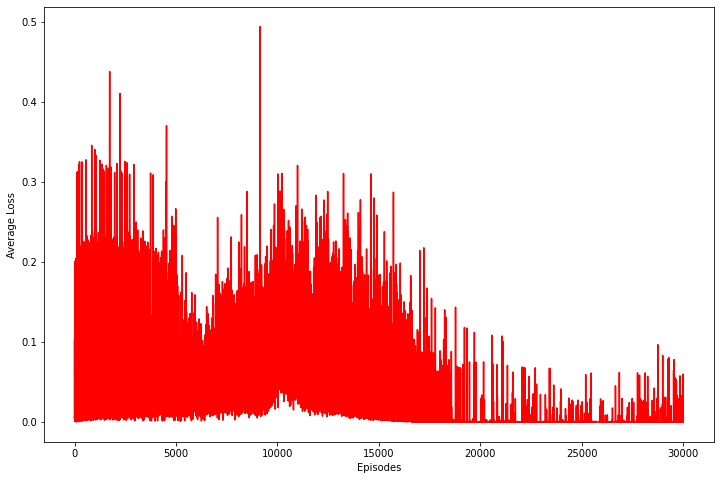

In [ ]:
dqn_model_ag1, dqn_model_ag2 = switch_main(env_name='Switch2-v1', num_episodes=30000, batch_size=128, gamma=0.95, learningrate=0.00005, epsilon_start=0.95, epsilon_final=0.0001, epsilon_decay=500)

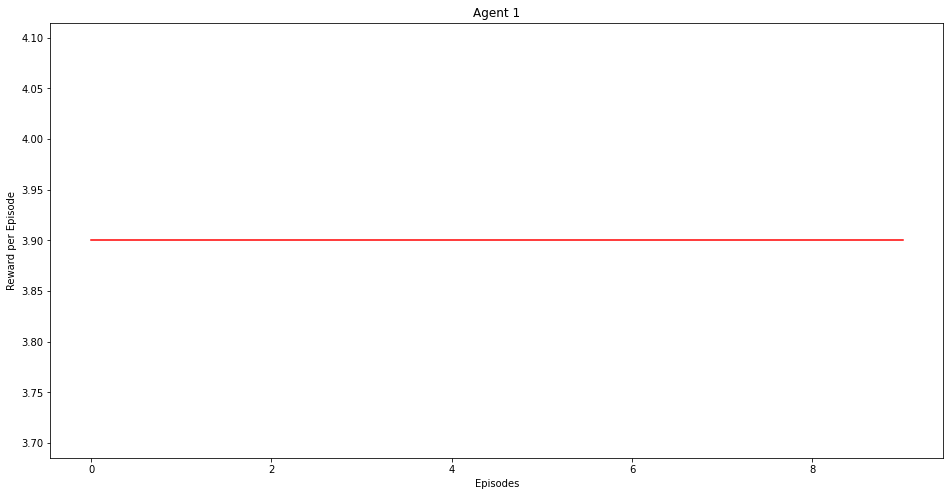

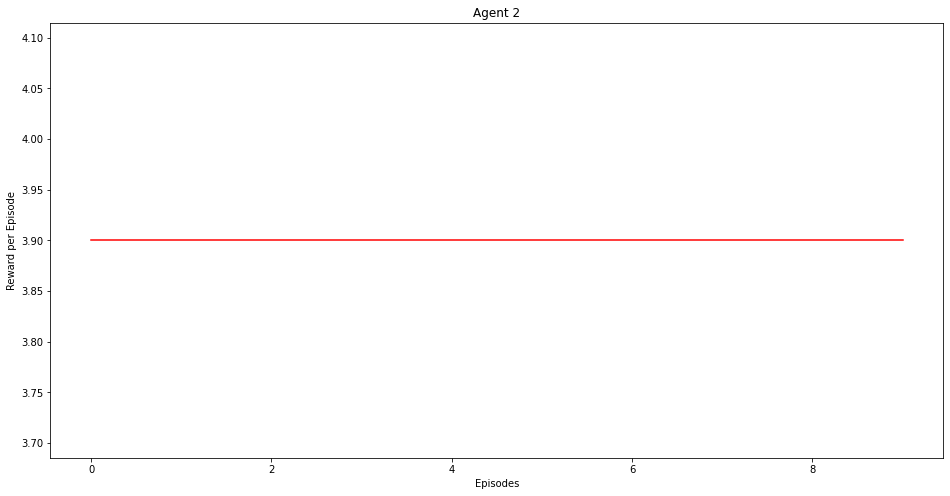

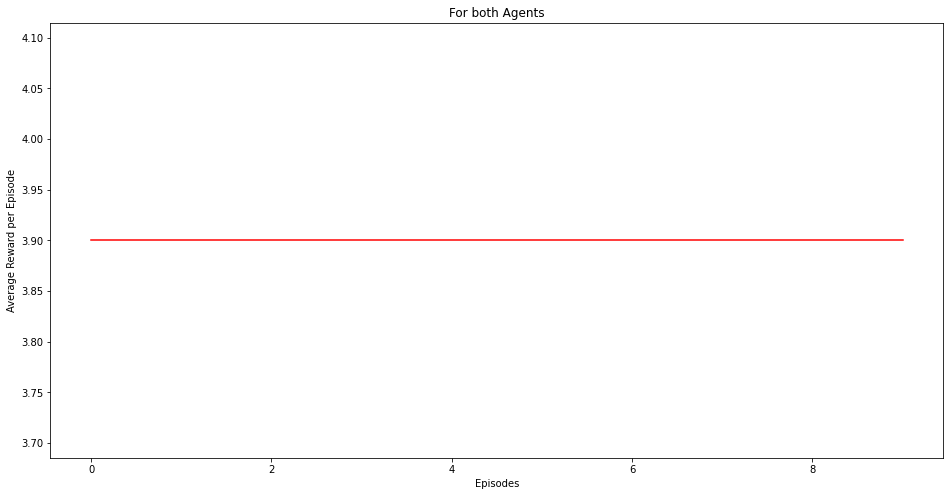

In [ ]:
evalTrainedModel('Switch2-v1', dqn_model_ag1, dqn_model_ag2)